In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# general packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', 50)

# graphing/visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
import sklearn
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import xgboost
from xgboost import XGBClassifier

import lightgbm
from lightgbm import LGBMClassifier


In [2]:
# python package versions
print("numpy version is:{}".format(np.__version__))
print("pandas version is:{}".format(pd.__version__))
print("matplotlib version is:{}".format(matplotlib.__version__))
print("scikit-learn version is:{}".format(sklearn.__version__))
print("xgboost version is:{}".format(xgboost.__version__))
print("lightgbm version is:{}".format(lightgbm.__version__))


numpy version is:1.26.4
pandas version is:2.2.3
matplotlib version is:3.7.2
scikit-learn version is:1.2.2
xgboost version is:2.0.3
lightgbm version is:4.6.0


In [3]:
# look at training data

# load data into dataframe
train_df= pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')

# look at first few rows of data and shape
print('Training data')
print('size of training data is:{}'.format(train_df.shape))
print(train_df.head())

# check for null
print('\n', train_df.info())

Training data
size of training data is:(19219, 35)
   id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0   0        584        590     909972     909977            16            8   
1   1        808        816     728350     728372           433           20   
2   2         39        192    2212076    2212144         11388          705   
3   3        781        789    3353146    3353173           210           16   
4   4       1540       1560     618457     618502           521           72   

   Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0            5               2274                    113   
1           54              44478                     70   
2          420            1311391                     29   
3           29               3202                    114   
4           67              48231                     82   

   Maximum_of_Luminosity  Length_of_Conveyer  TypeOfSteel_A300  \
0                    140                1

No null values.  All features and targets are numeric.

In [4]:
# look at steel features

train_df['sum_steel']= train_df['TypeOfSteel_A300'] + train_df['TypeOfSteel_A400']
train_df= train_df[train_df['sum_steel'] == 1].reset_index(drop= True)

train_df['sum_steel'].value_counts()

sum_steel
1    19198
Name: count, dtype: int64

Now all rows are either A300 or A400 steel.

In [5]:
# split training into x and y
# target labels
target_labels= ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

# split data into x and y
y_train= train_df.loc[:, target_labels]
x_train= train_df.drop(target_labels, axis= 1)

# look at x data and shape
print('x train dataframe')
print(x_train.head())
print('shape of x train:{}'.format(x_train.shape))

# look at y data and shape
print('\ny train dataframe')
print(y_train.head())
print('shape of y train:{}'.format(y_train.shape))

x train dataframe
   id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0   0        584        590     909972     909977            16            8   
1   1        808        816     728350     728372           433           20   
2   2         39        192    2212076    2212144         11388          705   
3   3        781        789    3353146    3353173           210           16   
4   4       1540       1560     618457     618502           521           72   

   Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0            5               2274                    113   
1           54              44478                     70   
2          420            1311391                     29   
3           29               3202                    114   
4           67              48231                     82   

   Maximum_of_Luminosity  Length_of_Conveyer  TypeOfSteel_A300  \
0                    140                1358                 0   
1       

In [6]:
# feature engineering

# create x length feature
x_train['x_length']= x_train['X_Maximum'] - x_train['X_Minimum']
x_train['x_length']= x_train['x_length'].astype(float)
# create y length feature
x_train['y_length']= x_train['Y_Maximum'] - x_train['Y_Minimum']
x_train['y_length']= x_train['y_length'].astype(float)
# make y_length non zero (need to divide by y length to make aspect ratio feature)
x_train.loc[x_train['y_length'] == 0, 'y_length']= 0.01
x_train['aspect_ratio']= x_train['x_length'] / x_train['y_length']

# look at dataframe with new features
print('new training dataframe')
print(x_train.head())
print('shape of new dataframe is:{}'.format(x_train.shape))


new training dataframe
   id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0   0        584        590     909972     909977            16            8   
1   1        808        816     728350     728372           433           20   
2   2         39        192    2212076    2212144         11388          705   
3   3        781        789    3353146    3353173           210           16   
4   4       1540       1560     618457     618502           521           72   

   Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0            5               2274                    113   
1           54              44478                     70   
2          420            1311391                     29   
3           29               3202                    114   
4           67              48231                     82   

   Maximum_of_Luminosity  Length_of_Conveyer  TypeOfSteel_A300  \
0                    140                1358                 0   
1  

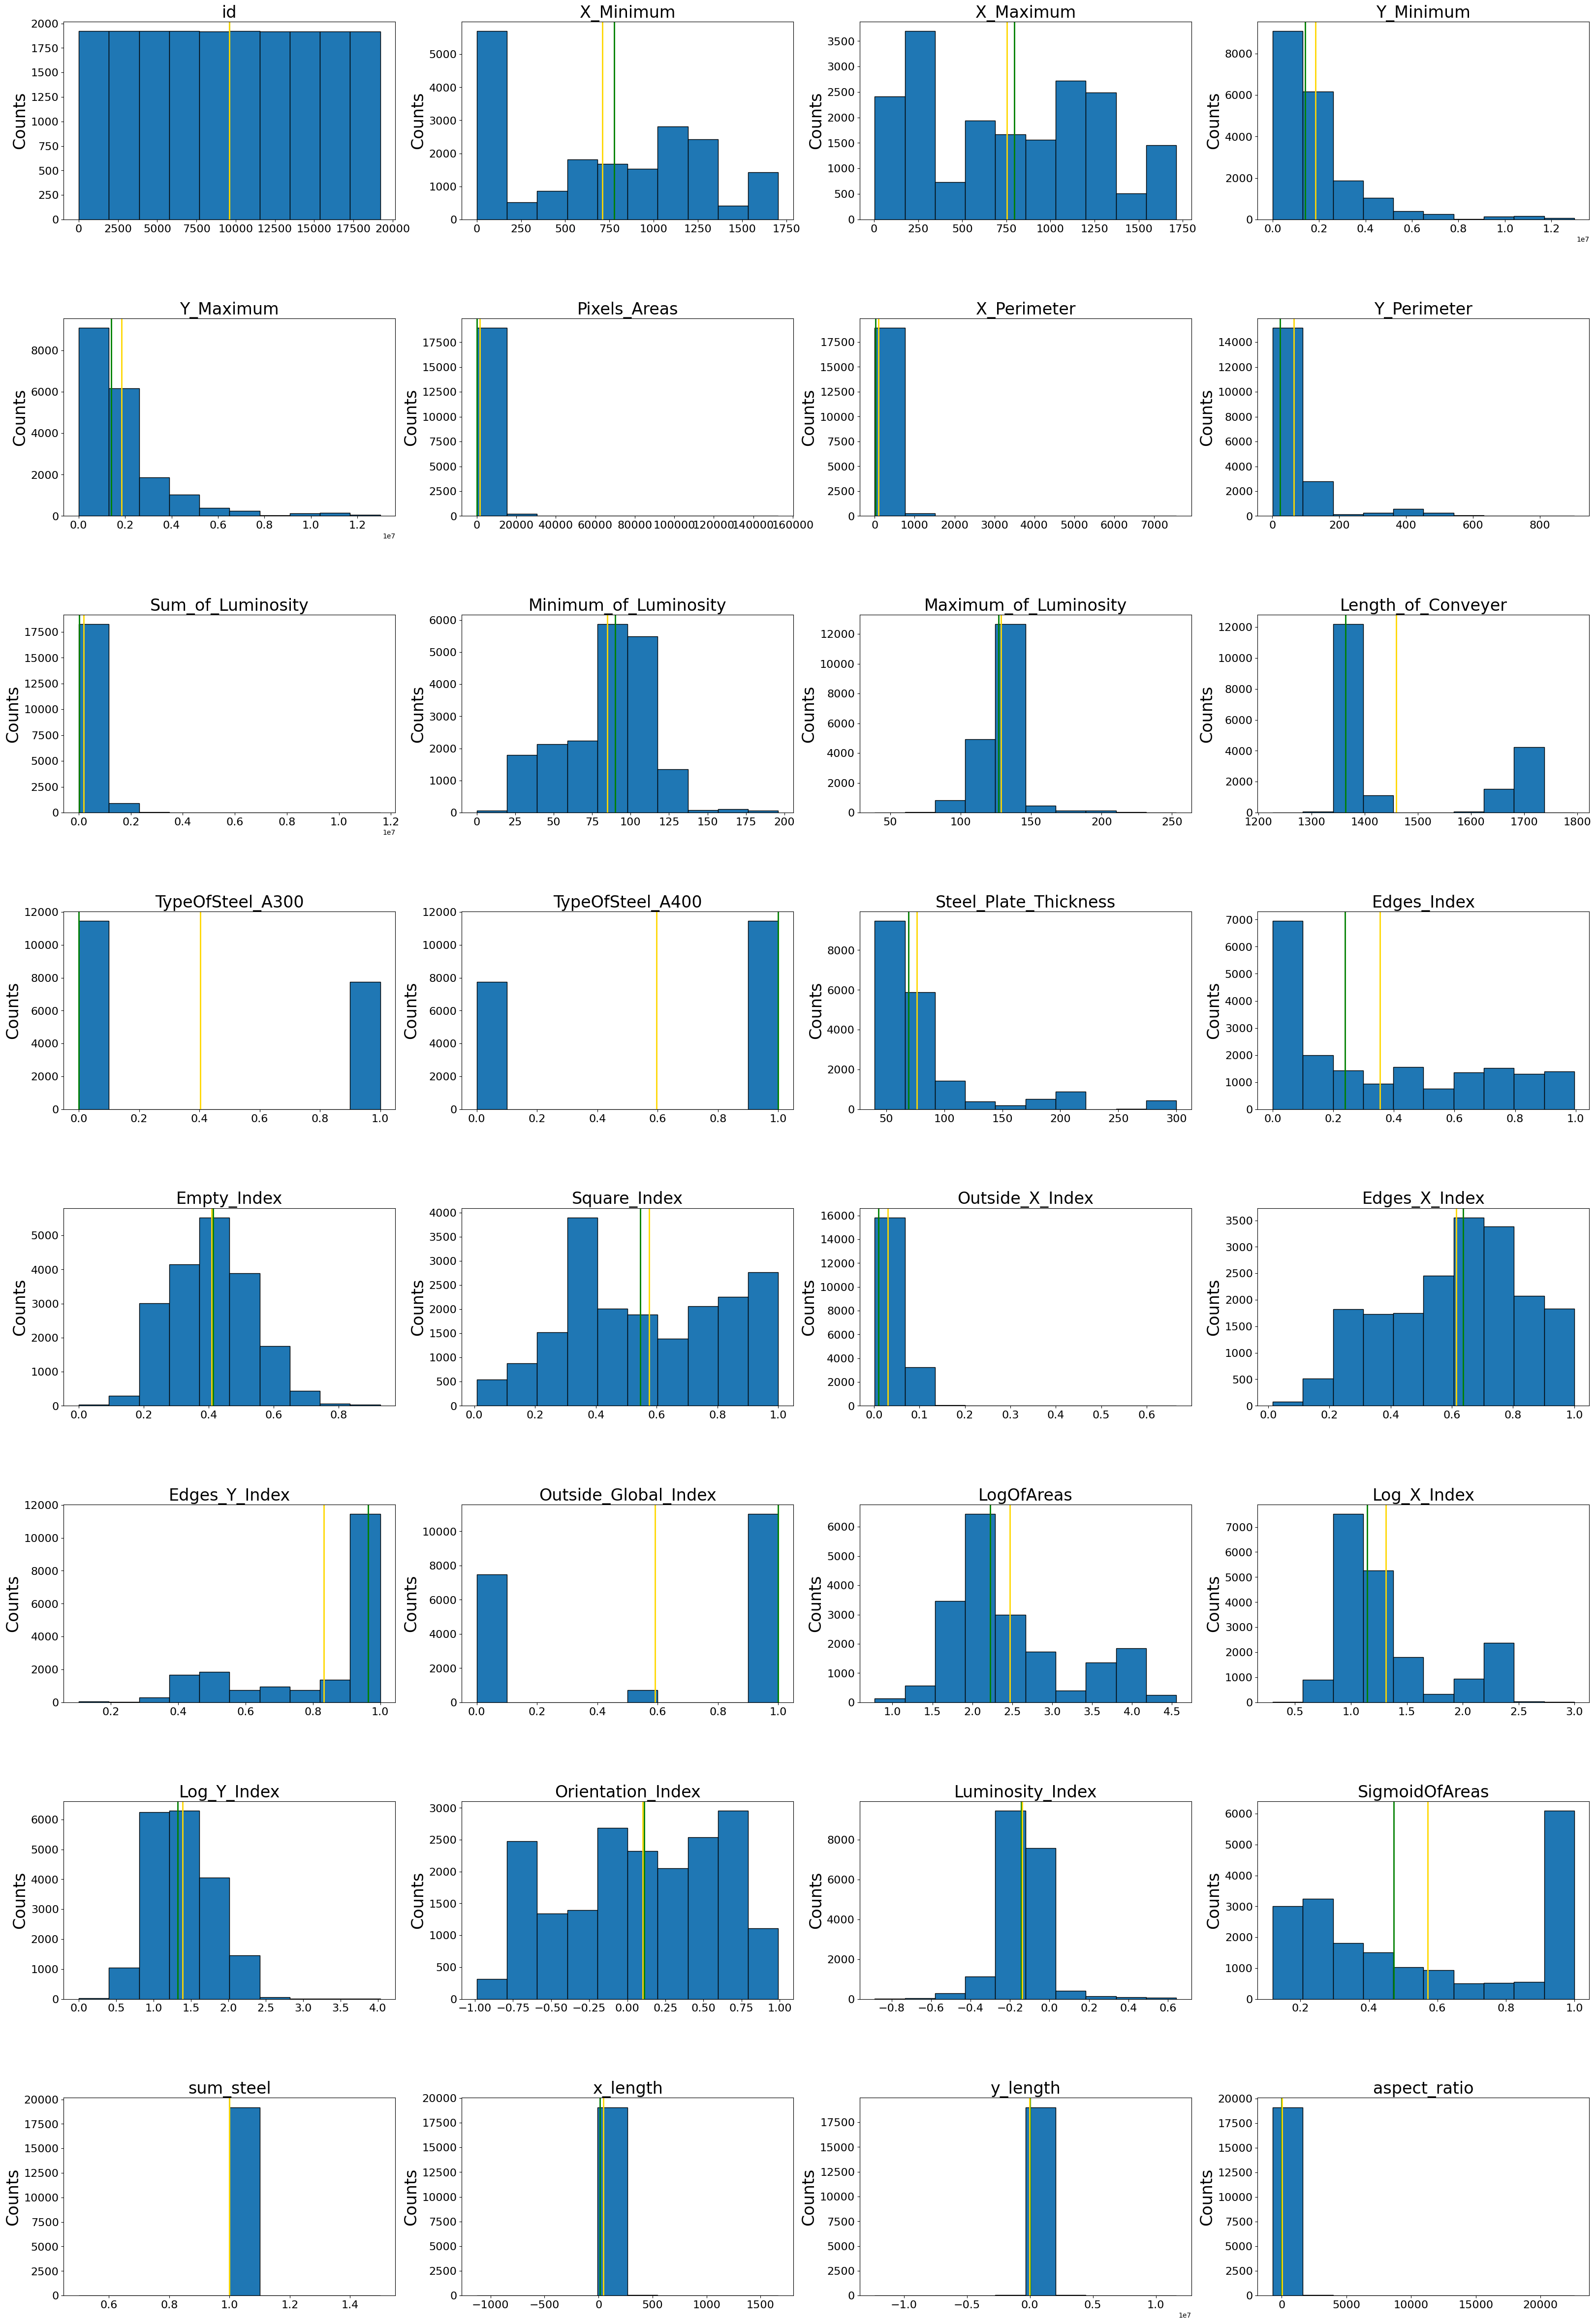

In [7]:
# look at distributions of training features with histogram

# initialize figure
fig1, ax1= plt.subplots(8, 4, figsize= (40, 60))
# figure spacing
plt.subplots_adjust(hspace= 0.5)

# initialize counter
count1= 0
# make loops for rows and columns
for i in range(8):
    for j in range(4):
        if count1 < len(x_train.columns.tolist()):
            # make histogram
            ax1[i, j].hist(x_train.iloc[:, count1], edgecolor= 'k')
            # add median line
            ax1[i, j].axvline(x_train.iloc[:, count1].median(), color= 'green', linewidth= 2, label= 'Median')
            # add average line
            ax1[i, j].axvline(x_train.iloc[:, count1].mean(), color= 'gold', linewidth= 2, label= 'Average')
            # formatting
            ax1[i, j].set_ylabel('Counts', fontsize= 24)
            ax1[i, j].set_title(x_train.columns.tolist()[count1], fontsize= 24)
            ax1[i, j].tick_params(axis= 'x', labelsize= 16)
            ax1[i, j].tick_params(axis= 'y', labelsize= 16)
            # increment counter
            count1= count1 + 1

y minimum, y maximum, y perimeter, steel plate thickness and edges index are heavily right skewed.  empty index, luminosity index, edge x index minimum of luminosity, maximum of luminosity and log y index are normally distributed.

In [8]:
# look at statistics of features

x_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,19198.0,9.604613e+03,5.547801e+03,0.000000e+00,4800.250000,9.602500e+03,1.440775e+04,1.921800e+04
X_Minimum,19198.0,7.104313e+02,5.314313e+02,0.000000e+00,50.000000,7.780000e+02,1.152000e+03,1.705000e+03
X_Maximum,19198.0,7.543294e+02,4.998167e+02,4.000000e+00,214.000000,7.960000e+02,1.166000e+03,1.713000e+03
Y_Minimum,19198.0,1.850268e+06,1.904440e+06,6.712000e+03,657468.000000,1.398169e+06,2.368032e+06,1.298766e+07
Y_Maximum,19198.0,1.847109e+06,1.897178e+06,6.724000e+03,657502.000000,1.398179e+06,2.364730e+06,1.298769e+07
Pixels_Areas,19198.0,1.675813e+03,3.720034e+03,6.000000e+00,89.000000,1.680000e+02,6.520000e+02,1.526550e+05
X_Perimeter,19198.0,9.526367e+01,1.772942e+02,2.000000e+00,15.000000,2.500000e+01,6.400000e+01,7.553000e+03
Y_Perimeter,19198.0,6.390051e+01,1.007265e+02,1.000000e+00,14.000000,2.300000e+01,6.075000e+01,9.030000e+02
Sum_of_Luminosity,19198.0,1.909410e+05,4.409188e+05,2.500000e+02,9805.250000,1.821800e+04,6.796700e+04,1.159141e+07
Minimum_of_Luminosity,19198.0,8.485347e+01,2.877179e+01,0.000000e+00,70.000000,9.000000e+01,1.050000e+02,1.960000e+02


Many features have huge range: X Minimum, X maximum, y Minimum, y maximum, pixel area, x perimeter, y perimeter.  pixel area, x perimeter and sum of luminosity all have very large outliers

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


<Axes: >

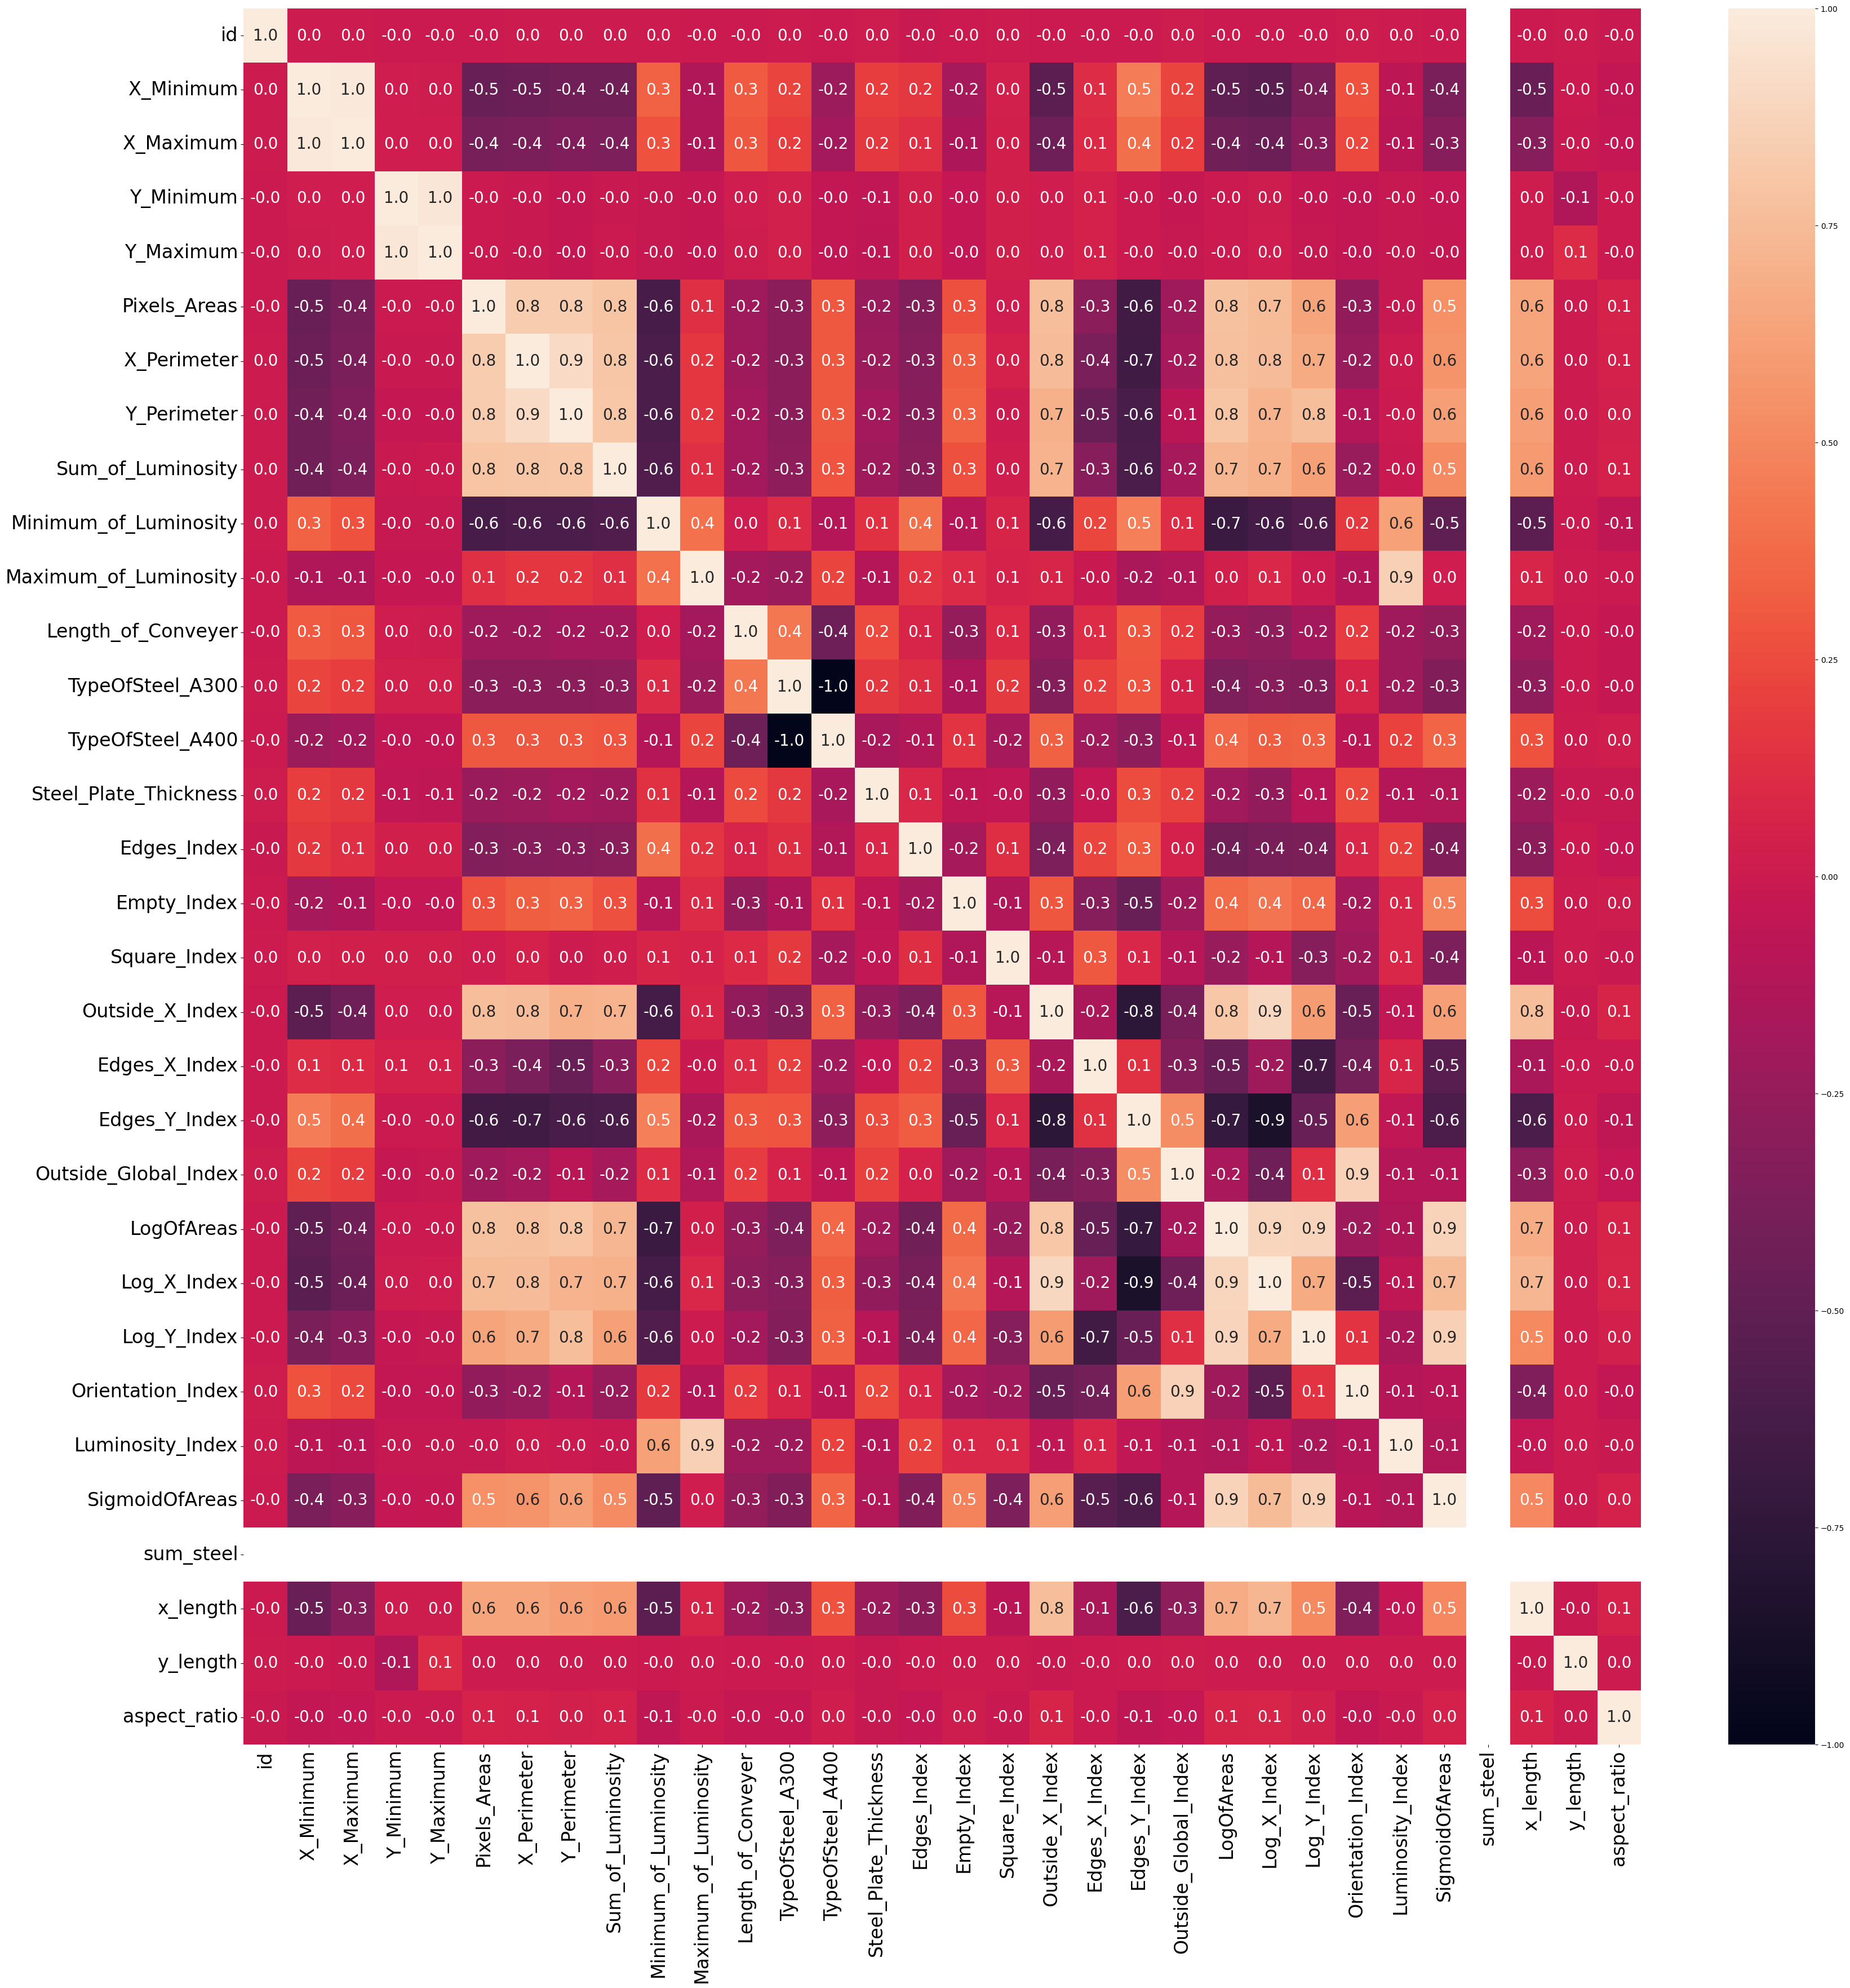

In [9]:
# look at correlations between features
plt.figure(figsize= (40, 40))
plt.xticks(fontsize= 24)
plt.yticks(fontsize= 24)
sns.heatmap(x_train.corr(), annot= True, fmt= '0.1f', annot_kws={'size':20})

High correlation between many features, will need to drop most of them.  High correlation between: x perimeter, y perimeter sum of luminosity and pixel areas.  Also high correlation between: log area, log x index, log y index, outside x index and sigmoid of areas.  Large negative correlation between edge y index and log of area and log x index.  Type of steel is binary: either A300 or A400.  

In [10]:
# look at target

# count of 1s for each target
y_train_1= y_train.sum().to_frame().T
y_train_1= y_train_1.rename({0:1})

# count of 0s for each target
y_train_0= y_train.shape[0] - y_train_1
y_train_0= y_train_0.rename({1:0})

# dataframe with counts for each target
y_train_counts= pd.concat([y_train_0, y_train_1], axis= 0)

print(y_train_counts)

# list of y train columns
y_train_col= sorted(y_train_counts.columns.tolist())

   Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
0   17733      18048     15783   18631      18713  14435         12643
1    1465       1150      3415     567        485   4763          6555


Dataset is highly imbalanced.  A lot more 0 than 1 for each defect.

/tmp/ipykernel_102/389703573.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2[i, j].set_yticklabels(ax2[i, j].get_yticklabels(), fontsize= 14)


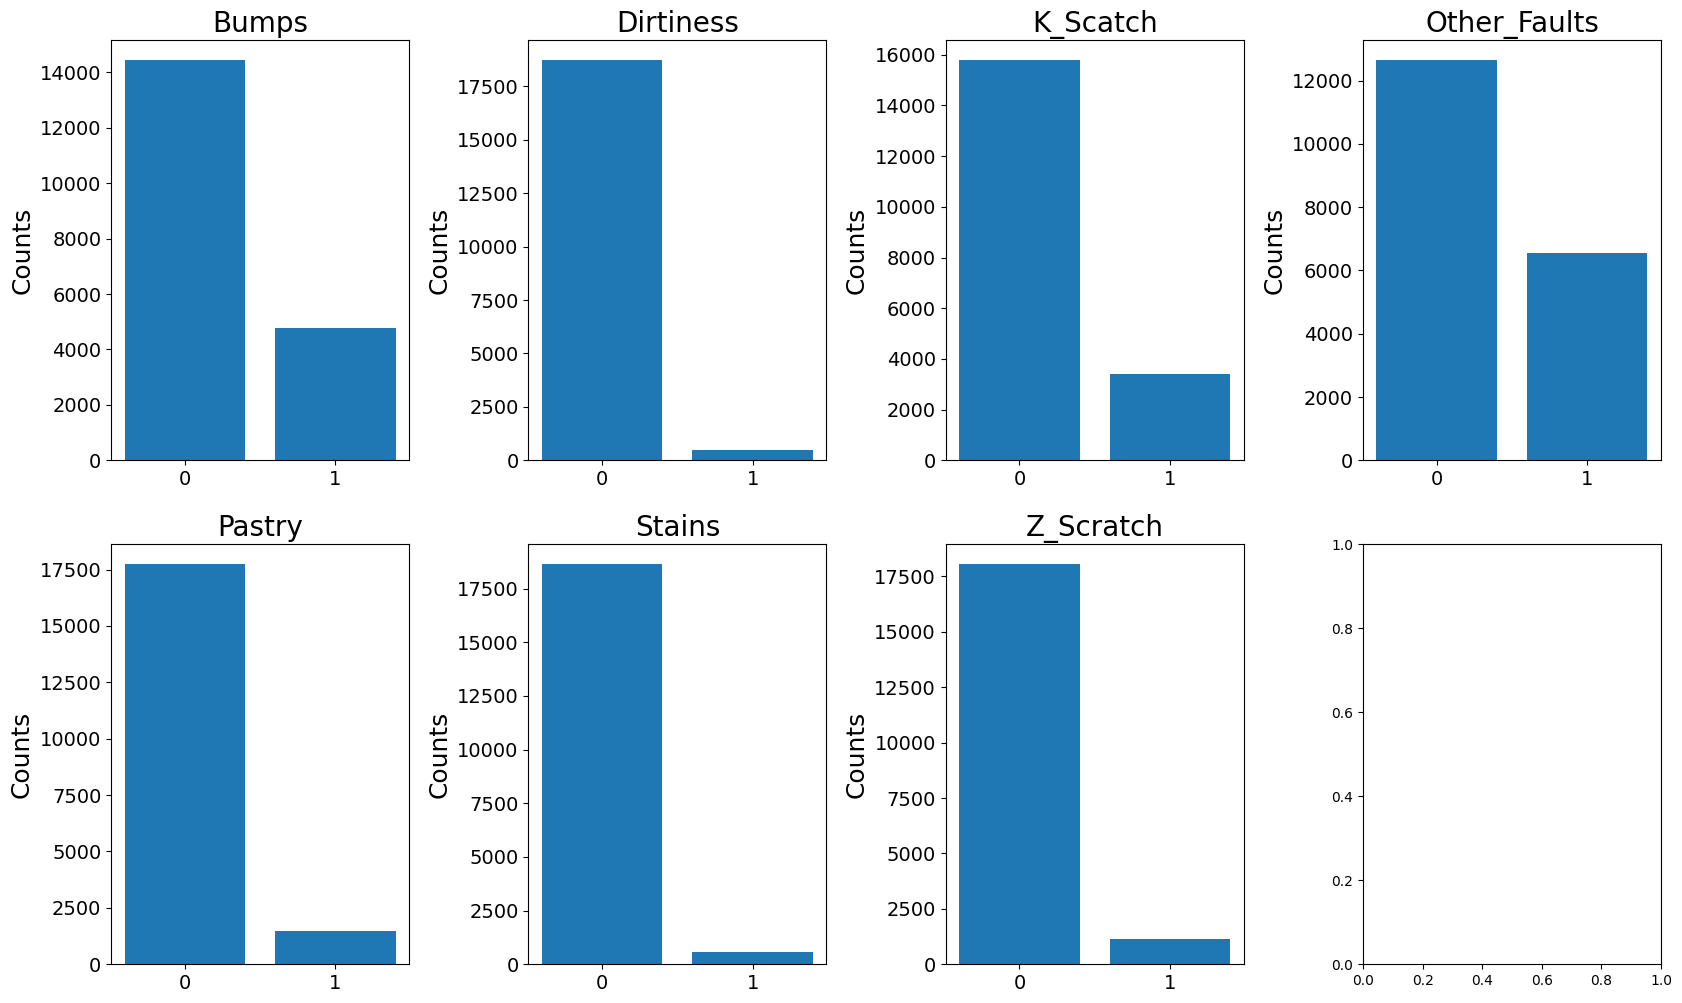

In [11]:
# plot target 0 vs 1 to visualize dataset imbalance
fig2, ax2= plt.subplots(2, 4, figsize= (20, 12))
plt.subplots_adjust(wspace= 0.4)
# make counter
count2= 0
# loops to make figures
for i in range(2):
    for j in range(4):
        if count2 < len(y_train_col):
            # make bar chart
            ax2[i, j].bar([0, 1], y_train_counts.loc[:, y_train_col[count2]])
            # format x tick labels
            ax2[i, j].set_xticks([0, 1])
            # format tick label size
            ax2[i, j].set_xticklabels(ax2[i, j].get_xticklabels(), fontsize= 14)
            ax2[i, j].set_yticklabels(ax2[i, j].get_yticklabels(), fontsize= 14)
            # set title 
            ax2[i, j].set_title(y_train_col[count2], fontsize= 20)
            # set y label
            ax2[i, j].set_ylabel('Counts', fontsize= 18)
            # increment counter
            count2= count2 + 1

Large imbalance between 0 and 1 for each target.   

In [12]:
# recombine each target to the features


# recombine x and y for each target
bumps_df= pd.concat([x_train, y_train['Bumps']], axis= 1)
dirty_df= pd.concat([x_train, y_train['Dirtiness']], axis= 1)
kscratch_df= pd.concat([x_train, y_train['K_Scatch']], axis= 1)
zscratch_df= pd.concat([x_train, y_train['Z_Scratch']], axis= 1)
other_df= pd.concat([x_train, y_train['Other_Faults']], axis= 1)
pastry_df= pd.concat([x_train, y_train['Pastry']], axis= 1)
stains_df= pd.concat([x_train, y_train['Stains']], axis= 1)


In [13]:
# make undersampled bumps df

# filtered dataframe for 0
bumps0= bumps_df[bumps_df['Bumps'] == 0]
# filtered dataframe for 1
bumps1= bumps_df[bumps_df['Bumps'] == 1]
size1= bumps1.shape[0]
# undersampled 0
under_bumps0= bumps0.sample(size1)

# combine 0 and 1 to make new dataframe
bumps= pd.concat([under_bumps0, bumps1], axis= 0).reset_index(drop= True)
# separate x and y for new dataframe
y_bumps= bumps['Bumps']
x_bumps= bumps.drop(['Bumps'], axis= 1)

# look at new dataframes
print('shape of x_bumps is:{}'.format(x_bumps.shape))
print(x_bumps.head())
print('\nshape of y_bumps is:{}'.format(y_bumps.shape))
print(y_bumps.head())
print('\nvalue counts for target')
print(y_bumps.value_counts())

# split into training and validation
x_train_bumps, x_val_bumps, y_train_bumps, y_val_bumps= train_test_split(x_bumps, y_bumps, test_size= 0.2, stratify= y_bumps, shuffle= True, random_state= 24)
# reset index
x_train_bumps= x_train_bumps.reset_index(drop= True)
x_val_bumps= x_val_bumps.reset_index(drop= True)
y_train_bumps= y_train_bumps.reset_index(drop= True)
y_val_bumps= y_val_bumps.reset_index(drop= True)

# check size
print('-'*80)
print('\nx_train_bumps')
print('size of x_train_bumps is: {}'.format(x_train_bumps.shape))
print('x_val_bumps')
print('size of x_val_bumps is: {}'.format(x_val_bumps.shape))
print('y_train_bumps')
print('size of y_train_bumps is: {}'.format(y_train_bumps.shape))
print('y_val_bumps')
print('size of y_val_bumps is: {}'.format(y_val_bumps.shape))

shape of x_bumps is:(9526, 32)
      id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  \
0  18361         39        191    1799909    1799959         16584   
1   6323       1289       1305     108596     108604            17   
2  12292        621        632    2020002    2020117          4346   
3  11376        413        434    1469673    1469845          3631   
4   9262         37        212    2222725    2222791          6281   

   X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0          617          424            2020624                     35   
1            8            5               2198                    111   
2          134          201             473046                    101   
3          187          104             373412                     37   
4          302          155             654358                     42   

   Maximum_of_Luminosity  Length_of_Conveyer  TypeOfSteel_A300  \
0                    141                140

In [14]:
# make undersampled dirty df

# filtered dataframe for 0
dirty0= dirty_df[dirty_df['Dirtiness'] == 0]
# filtered dataframe for 1
dirty1= dirty_df[dirty_df['Dirtiness'] == 1]
size2= dirty1.shape[0]
# undersampled 0
under_dirty0= dirty0.sample(size2)

# combine 0 and 1 to make new dataframe
dirty= pd.concat([under_dirty0, dirty1], axis= 0).reset_index(drop= True)
# separate x and y for new dataframe
y_dirty= dirty["Dirtiness"]
x_dirty= dirty.drop(['Dirtiness'], axis= 1)

# look at new dataframes
print('-'*80)
print('\nshape of x_dirty is:{}'.format(x_dirty.shape))
print(x_dirty.head())
print('\nshape of y_dirty is:{}'.format(y_dirty.shape))
print(y_dirty.head())
print('\nvalue counts for target')
print(y_dirty.value_counts())

# split into training and validation
x_train_dirty, x_val_dirty, y_train_dirty, y_val_dirty= train_test_split(x_dirty, y_dirty, 
                                test_size= 0.2, stratify= y_dirty, shuffle= True, random_state= 24)

# reset index
x_train_dirty= x_train_dirty.reset_index(drop= True)
x_val_dirty= x_val_dirty.reset_index(drop= True)
y_train_dirty= y_train_dirty.reset_index(drop= True)
y_val_dirty= y_val_dirty.reset_index(drop= True)

# check size
print('x_train_dirty')
print('size of x_train_dirty is: {}'.format(x_train_dirty.shape))
print('x_val_dirty')
print('size of x_val_dirty is: {}'.format(x_val_dirty.shape))
print('y_train_dirty')
print('size of y_train_dirty is: {}'.format(y_train_dirty.shape))
print('y_val_dirty')
print('size of y_val_dirty is: {}'.format(y_val_dirty.shape))

--------------------------------------------------------------------------------

shape of x_dirty is:(970, 32)
      id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  \
0  18472        609        621    1312199    1312217           181   
1  10173       1111       1130    1694534    1695447         25473   
2  14500        506        514     114430     114444            53   
3  17351       1287       1296   10440356   10440367            75   
4  13747       1641       1664    6791894    6791907            85   

   X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0           17           22              18654                     78   
1           38          380              29896                     49   
2           12           14               4690                     97   
3           15           12               8166                     85   
4           14           13               9137                     82   

   Maximum_of_Luminosity  Le

In [15]:
# make undersampled k_scratch df

# filtered dataframe for 0
kscratch0= kscratch_df[kscratch_df['K_Scatch'] == 0]
# filtered dataframe for 1
kscratch1= kscratch_df[kscratch_df['K_Scatch'] == 1]
size3= kscratch1.shape[0]
# undersampled 0
under_kscratch0= kscratch0.sample(size3)

# combine 0 and 1 to make new dataframe
kscratch= pd.concat([under_kscratch0, kscratch1], axis= 0).reset_index(drop= True)
# separate x and y for new dataframe
y_kscratch= kscratch['K_Scatch']
x_kscratch= kscratch.drop(['K_Scatch'], axis= 1)

# look at new dataframes
print('shape of x_kscratch is:{}'.format(x_kscratch.shape))
print(x_kscratch.head())
print('\nshape of y_kscratch is:{}'.format(y_kscratch.shape))
print(y_kscratch.head())
print('\nvalue counts for target')
print(y_kscratch.value_counts())

# split into training and validation
x_train_kscratch, x_val_kscratch, y_train_kscratch, y_val_kscratch= train_test_split(x_kscratch, y_kscratch, 
                                test_size= 0.2, stratify= y_kscratch, shuffle= True, random_state= 24)

# reset index
x_train_kscratch= x_train_kscratch.reset_index(drop= True)
x_val_kscratch= x_val_kscratch.reset_index(drop= True)
y_train_kscratch= y_train_kscratch.reset_index(drop= True)
y_val_kscratch= y_val_kscratch.reset_index(drop= True)

# check size
print('-'*80)
print('\nx_train_kscratch')
print('size of x_train_kscratch is: {}'.format(x_train_kscratch.shape))
print('x_val_kscratch')
print('size of x_val_kscratch is: {}'.format(x_val_kscratch.shape))
print('y_train_kscratch')
print('size of y_train_kscratch is: {}'.format(y_train_kscratch.shape))
print('y_val_kscratch')
print('size of y_val_kscratch is: {}'.format(y_val_kscratch.shape))

shape of x_kscratch is:(6830, 32)
      id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  \
0   9867        823        833    1738808    1738812           128   
1   6076        691        713    4822354    4822392           208   
2   4140       1327       1332    3023370    3023381            86   
3  13404         41        209    3778014    3778041          5753   
4   1153         23         46    1211332    1211367           706   

   X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0           10           18              18052                     99   
1           44           22              23267                     87   
2           14           15               8948                     91   
3          216          131             602131                     40   
4           43           61              60260                     90   

   Maximum_of_Luminosity  Length_of_Conveyer  TypeOfSteel_A300  \
0                    133                

In [16]:
# make undersampled z_scratch df

# filtered dataframe for 0
zscratch0= zscratch_df[zscratch_df['Z_Scratch'] == 0]
# filtered dataframe for 1
zscratch1= zscratch_df[zscratch_df['Z_Scratch'] == 1]
size4= zscratch1.shape[0]
# undersampled 0
under_zscratch0= zscratch0.sample(size4)

# combine 0 and 1 to make new dataframe
zscratch= pd.concat([under_zscratch0, zscratch1], axis= 0).reset_index(drop= True)
# separate x and y for new dataframe
y_zscratch= zscratch['Z_Scratch']
x_zscratch= zscratch.drop(['Z_Scratch'], axis= 1)

# look at new dataframes
print('-'*80)
print('\nshape of x_zscratch is:{}'.format(x_zscratch.shape))
print(x_zscratch.head())
print('\nshape of y_zscratch is:{}'.format(y_zscratch.shape))
print(y_zscratch.head())
print('\nvalue counts for target')
print(y_zscratch.value_counts())

# split into training and validation
x_train_zscratch, x_val_zscratch, y_train_zscratch, y_val_zscratch= train_test_split(x_zscratch, y_zscratch, 
                                test_size= 0.2, stratify= y_zscratch, shuffle= True, random_state= 24)

# reset index
x_train_zscratch= x_train_zscratch.reset_index(drop= True)
x_val_zscratch= x_val_zscratch.reset_index(drop= True)
y_train_zscratch= y_train_zscratch.reset_index(drop= True)
y_val_zscratch= y_val_zscratch.reset_index(drop= True)

# check size
print('x_train_zscratch')
print('size of x_train_zscratch is: {}'.format(x_train_zscratch.shape))
print('x_val_zscratch')
print('size of x_val_zscratch is: {}'.format(x_val_zscratch.shape))
print('y_train_zscratch')
print('size of y_train_zscratch is: {}'.format(y_train_zscratch.shape))
print('y_val_zscratch')
print('size of y_val_zscratch is: {}'.format(y_val_zscratch.shape))

--------------------------------------------------------------------------------

shape of x_zscratch is:(2300, 32)
      id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  \
0   4217         19         24     188768     188800            82   
1    472         41        218    2886302    2886367          6017   
2   4546         41        211    2275954    2276025          6337   
3  18850       1069       1090     301511     301492           108   
4  12967        312        322    2639665    2639674            65   

   X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0           15           23               7451                     73   
1          273          138             640970                     39   
2          286          147             656298                     46   
3           28           17              16538                    115   
4           10           12               7384                    103   

   Maximum_of_Luminosity

In [17]:
# make undersampled other_faults df

# filtered dataframe for 0
other0= other_df[other_df['Other_Faults'] == 0]
# filtered dataframe for 1
other1= other_df[other_df['Other_Faults'] == 1]
size5= other1.shape[0]
# undersampled 0
under_other0= other0.sample(size5)

# combine 0 and 1 to make new dataframe
other= pd.concat([under_other0, other1], axis= 0).reset_index(drop= True)
# separate x and y for new dataframe
y_other= other['Other_Faults']
x_other= other.drop(['Other_Faults'], axis= 1)

# look at new dataframes
print('shape of x_other is:{}'.format(x_other.shape))
print(x_other.head())
print('\nshape of y_other is:{}'.format(y_other.shape))
print(y_other.head())
print('\nvalue counts for target')
print(y_other.value_counts())

# split into training and validation
x_train_other, x_val_other, y_train_other, y_val_other= train_test_split(x_other, y_other, 
                                test_size= 0.2, stratify= y_other, shuffle= True, random_state= 24)

# reset index
x_train_other= x_train_other.reset_index(drop= True)
x_val_other= x_val_other.reset_index(drop= True)
y_train_other= y_train_other.reset_index(drop= True)
y_val_other= y_val_other.reset_index(drop= True)

# check size
print('-'*80)
print('\nx_train_other')
print('size of x_train_other is: {}'.format(x_train_other.shape))
print('x_val_other')
print('size of x_val_other is: {}'.format(x_val_other.shape))
print('y_train_other')
print('size of y_train_other is: {}'.format(y_train_other.shape))
print('y_val_other')
print('size of y_val_other is: {}'.format(y_val_other.shape))

shape of x_other is:(13110, 32)
      id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  \
0   2221       1587       1602     385532     385557           217   
1   4532         19         28    1620686    1620708           148   
2   5004         41         56    1736811    1736822           121   
3  10243       1586       1598    1779008    1779024           137   
4  12474        621        632    4758137    4758179           788   

   X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0           20           39              18651                     80   
1           19           22              12193                     51   
2           23           17              12367                     96   
3           16           16              13696                     81   
4           67           86              81625                     95   

   Maximum_of_Luminosity  Length_of_Conveyer  TypeOfSteel_A300  \
0                    108                16

In [18]:
# make undersampled pastry df

# filtered dataframe for 0
pastry0= pastry_df[pastry_df['Pastry'] == 0]
# filtered dataframe for 1
pastry1= pastry_df[pastry_df['Pastry'] == 1]
size6= pastry1.shape[0]
# undersampled 0
under_pastry0= pastry0.sample(size6)

# combine 0 and 1 to make new dataframe
pastry= pd.concat([under_pastry0, pastry1], axis= 0).reset_index(drop= True)
# separate x and y for new dataframe
y_pastry= pastry['Pastry']
x_pastry= pastry.drop(['Pastry'], axis= 1)

# look at new dataframes
print('-'*80)
print('\nshape of x_pastry is:{}'.format(x_pastry.shape))
print(x_pastry.head())
print('\nshape of y_pastry is:{}'.format(y_pastry.shape))
print(y_pastry.head())
print('\nvalue counts for target')
print(y_pastry.value_counts())

# split into training and validation
x_train_pastry, x_val_pastry, y_train_pastry, y_val_pastry= train_test_split(x_pastry, y_pastry, 
                                test_size= 0.2, stratify= y_pastry, shuffle= True, random_state= 24)

# reset index
x_train_pastry= x_train_pastry.reset_index(drop= True)
x_val_pastry= x_val_pastry.reset_index(drop= True)
y_train_pastry= y_train_pastry.reset_index(drop= True)
y_val_pastry= y_val_pastry.reset_index(drop= True)

# check size
print('x_train_pastry')
print('size of x_train_pastry is: {}'.format(x_train_pastry.shape))
print('x_val_pastry')
print('size of x_val_pastry is: {}'.format(x_val_pastry.shape))
print('y_train_pastry')
print('size of y_train_pastry is: {}'.format(y_train_pastry.shape))
print('y_val_pastry')
print('size of y_val_pastry is: {}'.format(y_val_pastry.shape))

--------------------------------------------------------------------------------

shape of x_pastry is:(2930, 32)
      id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  \
0  10032        634        655    1060291    1060313           229   
1   1170       1237       1248    5046506     504761            62   
2  16410        647        658    3257887    3257901           107   
3   5225       1617       1629    1346248    1346264           140   
4  12337       1348       1360     125025     125040           123   

   X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0           35           36              31538                     89   
1           12           10               6834                     86   
2           11           16              12571                    105   
3           25           20              13836                     64   
4           19           15              12652                     71   

   Maximum_of_Luminosity  

In [19]:
# make undersampled stains df

# filtered dataframe for 0
stains0= stains_df[stains_df['Stains'] == 0]
# filtered dataframe for 1
stains1= stains_df[stains_df['Stains'] == 1]
size7= stains1.shape[0]
# undersampled 0
under_stains0= stains0.sample(size7)

# combine 0 and 1 to make new dataframe
stains= pd.concat([under_stains0, stains1], axis= 0).reset_index(drop= True)
# separate x and y for new dataframe
y_stains= stains['Stains']
x_stains= stains.drop(['Stains'], axis= 1)

# look at new dataframes
print('shape of x_stains is:{}'.format(x_stains.shape))
print(x_stains.head())
print('\nshape of y_stains is:{}'.format(y_stains.shape))
print(y_stains.head())
print('\nvalue counts for target')
print(y_stains.value_counts())

# split into training and validation
x_train_stains, x_val_stains, y_train_stains, y_val_stains= train_test_split(x_stains, y_stains, 
                                test_size= 0.2, stratify= y_stains, shuffle= True, random_state= 24)

# reset index
x_train_stains= x_train_stains.reset_index(drop= True)
x_val_stains= x_val_stains.reset_index(drop= True)
y_train_stains= y_train_stains.reset_index(drop= True)
y_val_stains= y_val_stains.reset_index(drop= True)

# check size
print('-'*80)
print('\nx_train_stains')
print('size of x_train_stains is: {}'.format(x_train_stains.shape))
print('x_val_stains')
print('size of x_val_stains is: {}'.format(x_val_stains.shape))
print('y_train_stains')
print('size of y_train_stains is: {}'.format(y_train_stains.shape))
print('y_val_stains')
print('size of y_val_stains is: {}'.format(y_val_stains.shape))

shape of x_stains is:(1134, 32)
      id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  \
0  11115        810        814     425925     425936            36   
1   2162        853        877    1148345    1148364           617   
2   8974       1123       1140    2354334    2354684           128   
3   2365         45         62    1388292    1388304           115   
4   2929        981        992    2158132    2158152           267   

   X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0            9            4               4605                     97   
1           67           67              63880                     94   
2           15           15              13800                     79   
3           21           14              13108                    103   
4           25           52              28955                     87   

   Maximum_of_Luminosity  Length_of_Conveyer  TypeOfSteel_A300  \
0                    119                13

In [20]:
# lists of dataframes

x_train_list= [x_train_pastry, x_train_zscratch, x_train_kscratch, x_train_stains, 
               x_train_dirty, x_train_bumps, x_train_other]

x_val_list= [x_val_pastry, x_val_zscratch, x_val_kscratch, x_val_stains, 
             x_val_dirty, x_val_bumps, x_val_other]

y_train_list= [y_train_pastry, y_train_zscratch, y_train_kscratch, y_train_stains, 
               y_train_dirty, y_train_bumps, y_train_other]

y_val_list= [y_val_pastry, y_val_zscratch, y_val_kscratch, y_val_stains, 
             y_val_dirty, y_val_bumps, y_val_other]

target_labels= ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

In [21]:
# columns to drop
drop_col= ['id', 'sum_steel', 'TypeOfSteel_A300', 'X_Minimum', 'Y_Minimum', 
           'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 
           'Log_X_Index', 'Log_Y_Index', 'SigmoidOfAreas',
           'Edges_Y_Index', 'Outside_X_Index', 'Outside_Global_Index']

# drop columns from training dataframes
for i, j in enumerate(x_train_list):
    j.drop(drop_col, axis= 1, inplace= True)
    print('train df {} dropped columns new size is: {}'.format(i + 1, j.shape))

# drop columns from validation dataframes
for k, m in enumerate(x_val_list):
    m.drop(drop_col, axis= 1, inplace= True)
    print('val df {} dropped columns new size is: {}'.format(k + 1, m.shape))

train df 1 dropped columns new size is: (2344, 18)
train df 2 dropped columns new size is: (1840, 18)
train df 3 dropped columns new size is: (5464, 18)
train df 4 dropped columns new size is: (907, 18)
train df 5 dropped columns new size is: (776, 18)
train df 6 dropped columns new size is: (7620, 18)
train df 7 dropped columns new size is: (10488, 18)
val df 1 dropped columns new size is: (586, 18)
val df 2 dropped columns new size is: (460, 18)
val df 3 dropped columns new size is: (1366, 18)
val df 4 dropped columns new size is: (227, 18)
val df 5 dropped columns new size is: (194, 18)
val df 6 dropped columns new size is: (1906, 18)
val df 7 dropped columns new size is: (2622, 18)


In [22]:
# scale features

# training and validation
x_train_scaled= []
x_val_scaled= []
for i, j in enumerate(x_train_list):
    # initialize scaler
    scaler= MinMaxScaler()
    # fit and transform training
    train_scaled= scaler.fit_transform(j)
    train_scaled_df= pd.DataFrame(train_scaled, columns= j.columns)
    x_train_scaled.append(train_scaled_df)
    print('max for scaled training dataframe is: {}'.format(train_scaled_df.max().max()))

    #transform validation
    val_scaled= scaler.transform(x_val_list[i])
    val_scaled_df= pd.DataFrame(val_scaled, columns= j.columns)
    x_val_scaled.append(val_scaled_df)
    print('max for scaled validation dataframe is: {}'.format(val_scaled_df.max().max()))

max for scaled training dataframe is: 1.0
max for scaled validation dataframe is: 1.0749879051765845
max for scaled training dataframe is: 1.0000000000000004
max for scaled validation dataframe is: 1.1848484848484848
max for scaled training dataframe is: 1.0
max for scaled validation dataframe is: 1.0177344150068726
max for scaled training dataframe is: 1.0000000000000002
max for scaled validation dataframe is: 1.0833333333333333
max for scaled training dataframe is: 1.0000000000000004
max for scaled validation dataframe is: 1.0738879184131431
max for scaled training dataframe is: 1.0
max for scaled validation dataframe is: 1.3057221965851407
max for scaled training dataframe is: 1.0000000000000002
max for scaled validation dataframe is: 1.0


In [23]:
# function to train evaluate and predict

# include avg in labels
target_labels.append('Average')

def metric_fn(model1, name1):
    score_train= []
    score_val= []
    for i, j in enumerate(x_train_scaled):
        # fit model on training
        model1.fit(j, y_train_list[i])
        # predict training probabilities
        y_pred_train= model1.predict_proba(j)[:, 1]
        # evaluate training
        auc_train= roc_auc_score(y_train_list[i], y_pred_train)
        score_train.append(auc_train)
        name2= name1 + "_train"
        # predict validation probabilities
        y_pred_val= model1.predict_proba(x_val_scaled[i])[:, 1]
        # evaluate validation
        auc_val= roc_auc_score(y_val_list[i], y_pred_val)
        score_val.append(auc_val)
        name3= name1 + "_val"
        #print('done with dataframe {}'.format(i + 1))
    # find average auc score for training
    avg_train= sum(score_train)/len(score_train)
    score_train.append(avg_train)
    # find average auc score for validation
    avg_val= sum(score_val)/len(score_val)
    score_val.append(avg_val)
    # make dataframe for training auc scores
    df1= pd.DataFrame([score_train], columns= target_labels, index= [name2])
    # make dataframe for validation auc scores
    df2= pd.DataFrame([score_val], columns= target_labels, index= [name3])
    df3= pd.concat([df1, df2], axis= 0)
    return df3

In [24]:
# model 1: logistic regression

log1= LogisticRegression(solver= 'newton-cholesky', random_state= 24)

log_df= metric_fn(log1, 'log_reg')

print(log_df)

                 Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness     Bumps  \
log_reg_train  0.849307   0.909309  0.978186  0.982705   0.848177  0.735011   
log_reg_val    0.853231   0.916314  0.975532  0.995963   0.832395  0.737653   

               Other_Faults   Average  
log_reg_train      0.671365  0.853437  
log_reg_val        0.664458  0.853649  


no evidence of overfitting.  stains and k scratch predicted very well.  other faults and bumps arent predicted as well.

In [25]:
# model 2: decision tree

tree1= DecisionTreeClassifier(random_state= 24)

tree_df= metric_fn(tree1, 'Decision_tree')

print(tree_df)

                       Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness  \
Decision_tree_train  1.000000   1.000000  1.000000  1.000000   1.000000   
Decision_tree_val    0.697952   0.828261  0.904832  0.925167   0.680412   

                        Bumps  Other_Faults   Average  
Decision_tree_train  1.000000      1.000000  1.000000  
Decision_tree_val    0.643232      0.561022  0.748697  


decision tree model is overfit.

In [26]:
# model 3: random forest

forest1= RandomForestClassifier(random_state= 24)

forest_df= metric_fn(forest1, 'Random_forest')

print(forest_df)

                       Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness  \
Random_forest_train  1.000000   1.000000  1.000000  1.000000    1.00000   
Random_forest_val    0.864134   0.951087  0.979663  0.992509    0.85466   

                        Bumps  Other_Faults   Average  
Random_forest_train  1.000000      1.000000  1.000000  
Random_forest_val    0.789327      0.683148  0.873504  


pastry, bumps and other faults are overfit.  z scratch, k scratch and stains are well fit.

In [27]:
# model 4: xgboost

boost1= XGBClassifier(eval_metric= 'auc', objective= 'binary:logistic', random_state= 24)

boost_df= metric_fn(boost1, 'xgboost')

print(boost_df)

                 Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness     Bumps  \
xgboost_train  1.000000   1.000000  1.000000  1.000000   1.000000  0.996828   
xgboost_val    0.849445   0.949887  0.976833  0.989598   0.852694  0.778504   

               Other_Faults   Average  
xgboost_train      0.985209  0.997434  
xgboost_val        0.664986  0.865992  


pastry, bumps and other faults are overfit.  z scratch, k scratch and stains are well fit.

In [28]:
# model 5: lightgbm

light1= LGBMClassifier(metric= 'auc', random_state= 24)

light_df= metric_fn(light1, 'lightGBM')

print(light_df)

[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3337
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 920, number of negative: 920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 1840, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2732, number of negative: 27

pastry, bumps and other faults are overfit.  z scratch, k scratch and stains are well fit.

Best average auc score for validation was lightGBM model.

In [29]:
# use full undersampled majority dataframes for fitting training
# lists with full undersampled majority dataframes
xtrain_list= [x_pastry, x_zscratch, x_kscratch, x_stains, x_dirty, x_bumps, x_other]
ytrain_list= [y_pastry, y_zscratch, y_kscratch, y_stains, y_dirty, y_bumps, y_other]

# drop columns
for i in xtrain_list:
    i.drop(drop_col, axis= 1, inplace= True)
    print(i.head())
    print('shape of new dataframe is: {}'.format(i.shape))

   X_Maximum  Y_Maximum  Sum_of_Luminosity  Minimum_of_Luminosity  \
0        655    1060313              31538                     89   
1       1248     504761               6834                     86   
2        658    3257901              12571                    105   
3       1629    1346264              13836                     64   
4       1360     125040              12652                     71   

   Maximum_of_Luminosity  Length_of_Conveyer  TypeOfSteel_A400  \
0                    132                1374                 1   
1                    110                1360                 0   
2                    124                1690                 1   
3                    132                1688                 0   
4                    127                1623                 0   

   Steel_Plate_Thickness  Edges_Index  Empty_Index  Square_Index  \
0                     40       0.9106       0.5022        1.0000   
1                    185       0.0722       0.1556  

In [30]:
# read test data
test_df= pd.read_csv("/kaggle/input/playground-series-s4e3/test.csv")

test_df.head()

test_id= test_df['id']

# add features
test_df['sum_steel']= test_df['TypeOfSteel_A300'] + test_df['TypeOfSteel_A400']
# create x length feature
test_df['x_length']= test_df['X_Maximum'] - test_df['X_Minimum']
test_df['x_length']= test_df['x_length'].astype(float)
# create y length feature
test_df['y_length']= test_df['Y_Maximum'] - test_df['Y_Minimum']
test_df['y_length']= test_df['y_length'].astype(float)
# make y_length non zero (need to divide by y length to make aspect ratio feature)
test_df.loc[test_df['y_length'] == 0, 'y_length']= 0.01
test_df['aspect_ratio']= test_df['x_length'] / test_df['y_length']

# drop columns
test_drop= test_df.drop(drop_col, axis= 1)

# look at new test dataframe
print(test_drop.head())
print('shape of test is: {}'.format(test_drop.shape))

   X_Maximum  Y_Maximum  Sum_of_Luminosity  Minimum_of_Luminosity  \
0       1033    3826588              62357                     67   
1       1271     419973              39293                     92   
2       1372     117724              29386                    101   
3        168     232440               8586                    107   
4        592     544389              15524                    103   

   Maximum_of_Luminosity  Length_of_Conveyer  TypeOfSteel_A400  \
0                    127                1656                 1   
1                    132                1354                 1   
2                    134                1360                 1   
3                    140                1690                 0   
4                    134                1688                 0   

   Steel_Plate_Thickness  Edges_Index  Empty_Index  Square_Index  \
0                    150       0.3877       0.4896        0.3273   
1                     40       0.1629       0.4136  

In [31]:
# need to scale test and training dataframes
xtest_scaled= []
xtrain_scaled= []

for i in xtrain_list:
    scaler= MinMaxScaler()
    # fit transform training
    train_scaled= scaler.fit_transform(i)
    train_scaled= pd.DataFrame(train_scaled, columns= i.columns)
    xtrain_scaled.append(train_scaled)
    print('_'*80)
    print(train_scaled.head())

    # transform test
    test_scaled= scaler.transform(test_drop)
    test_scaled= pd.DataFrame(test_scaled, columns= test_drop.columns)
    xtest_scaled.append(test_scaled)

xtest_scaled= sum(xtest_scaled) / len(xtest_scaled)

# look at scaled test
print('_'*80)
print('average scaled test dataframe')
print(xtest_scaled.head())

________________________________________________________________________________
   X_Maximum  Y_Maximum  Sum_of_Luminosity  Minimum_of_Luminosity  \
0   0.380925   0.081164           0.007985               0.456410   
1   0.727911   0.038367           0.001679               0.441026   
2   0.382680   0.250457           0.003143               0.538462   
3   0.950848   0.103193           0.003466               0.328205   
4   0.793446   0.009115           0.003164               0.364103   

   Maximum_of_Luminosity  Length_of_Conveyer  TypeOfSteel_A400  \
0               0.429577            0.301230               1.0   
1               0.274648            0.272541               0.0   
2               0.373239            0.948770               1.0   
3               0.429577            0.944672               0.0   
4               0.394366            0.811475               0.0   

   Steel_Plate_Thickness  Edges_Index  Empty_Index  Square_Index  \
0               0.000000     0.914992  

In [32]:
# generate predictions using lightgbm

y_test_pred_all= pd.DataFrame()
for i, j in enumerate(xtrain_scaled):
    light2= LGBMClassifier(metric= 'auc', random_state= 24)
    # fit model
    light2.fit(j, ytrain_list[i])
    # predict probabilities
    y_test_pred1= light2.predict_proba(xtest_scaled)[:, 1]
    y_test_pred= pd.Series(y_test_pred1, name= target_labels[i])
    y_test_pred_all= pd.concat([y_test_pred_all, y_test_pred], axis= 1)

# add id to predictions
sub_df= pd.concat([test_id, y_test_pred_all], axis= 1)

# export submission file for competition
sub_df.to_csv('/kaggle/working/submission.csv', index= False)
    
    

[LightGBM] [Info] Number of positive: 1465, number of negative: 1465
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3368
[LightGBM] [Info] Number of data points in the train set: 2930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1150, number of negative: 1150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3329
[LightGBM] [Info] Number of data points in the train set: 2300, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3415, number of negative: 3415
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t